In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!unzip "/content/drive/MyDrive/Dataset.zip"

Archive:  /content/drive/MyDrive/Dataset.zip
replace 105_classes_pins_dataset/pins_Adriana Lima/Adriana Lima0_0.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
import cv2 as cv
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [ ]:
img = cv.imread("/content/105_classes_pins_dataset/pins_Katherine Langford/Katherine Langford0_2871.jpg")

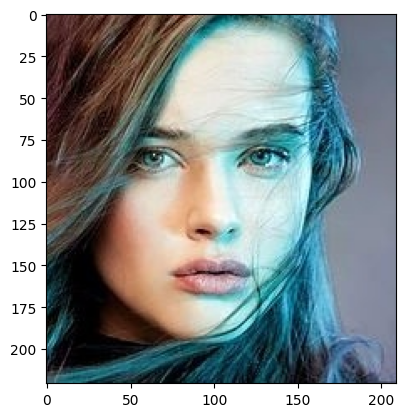

In [ ]:
img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
plt.imshow(img) # RGB

In [ ]:
!pip install lz4

In [ ]:
!pip install mtcnn

In [ ]:
from mtcnn.mtcnn import MTCNN

detector = MTCNN()
results = detector.detect_faces(img)

In [ ]:
results

[{'box': [28, 15, 131, 178],
  'confidence': np.float64(0.9998144507408142),
  'keypoints': {'nose': [np.int64(101), np.int64(126)],
   'mouth_right': [np.int64(119), np.int64(156)],
   'right_eye': [np.int64(130), np.int64(84)],
   'left_eye': [np.int64(66), np.int64(85)],
   'mouth_left': [np.int64(75), np.int64(156)]}}]

In [ ]:
x,y,w,h = results[0]['box']

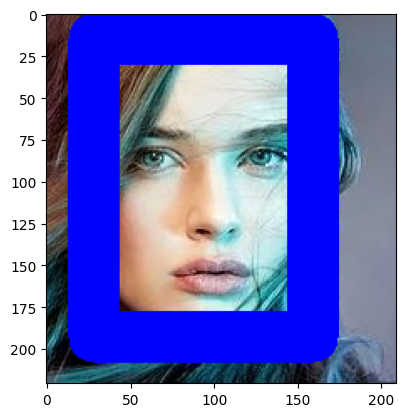

In [ ]:
img = cv.rectangle(img, (x,y), (x+w, y+h), (0,0,255), 30)
plt.imshow(img)

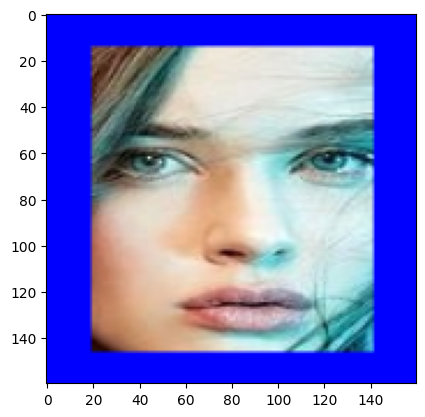

In [ ]:
my_face = img[y:y+h, x:x+w]
my_face = cv.resize(my_face, (160,160))
plt.imshow(my_face)

array([[[  0,   0, 255],
        [  0,   0, 255],
        [  0,   0, 255],
        ...,
        [  0,   0, 255],
        [  0,   0, 255],
        [  0,   0, 255]],

       [[  0,   0, 255],
        [  0,   0, 255],
        [  0,   0, 255],
        ...,
        [  0,   0, 255],
        [  0,   0, 255],
        [  0,   0, 255]],

       [[  0,   0, 255],
        [  0,   0, 255],
        [  0,   0, 255],
        ...,
        [  0,   0, 255],
        [  0,   0, 255],
        [  0,   0, 255]],

       ...,

       [[  0,   0, 255],
        [  0,   0, 255],
        [  0,   0, 255],
        ...,
        [  0,   0, 255],
        [  0,   0, 255],
        [  0,   0, 255]],

       [[  0,   0, 255],
        [  0,   0, 255],
        [  0,   0, 255],
        ...,
        [  0,   0, 255],
        [  0,   0, 255],
        [  0,   0, 255]],

       [[  0,   0, 255],
        [  0,   0, 255],
        [  0,   0, 255],
        ...,
        [  0,   0, 255],
        [  0,   0, 255],
        [  0,   0, 255]]], dtype=uint8)
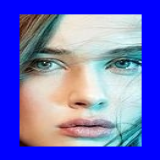

In [ ]:
my_face

# **Preprocessing**

In [ ]:
class FACELOADING:
    def __init__(self, directory):
        self.directory = directory
        self.target_size = (160,160)
        self.X = []
        self.Y = []
        self.detector = MTCNN()


    def extract_face(self, filename):
        img = cv.imread(filename)
        img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
        x,y,w,h = self.detector.detect_faces(img)[0]['box']
        x,y = abs(x), abs(y)
        face = img[y:y+h, x:x+w]
        face_arr = cv.resize(face, self.target_size)
        return face_arr


    def load_faces(self, dir):
        FACES = []
        for im_name in os.listdir(dir):
            try:
                path = dir + im_name
                single_face = self.extract_face(path)
                FACES.append(single_face)
            except Exception as e:
                pass
        return FACES

    def load_classes(self):
        for sub_dir in os.listdir(self.directory):
            path = self.directory +'/'+ sub_dir+'/'
            FACES = self.load_faces(path)
            labels = [sub_dir for _ in range(len(FACES))]
            print(f"Loaded successfully: {len(labels)}")
            self.X.extend(FACES)
            self.Y.extend(labels)

        return np.asarray(self.X), np.asarray(self.Y)


    def plot_images(self):
        plt.figure(figsize=(18,16))
        for num,image in enumerate(self.X):
            ncols = 3
            nrows = len(self.Y)//ncols + 1
            plt.subplot(nrows,ncols,num+1)
            plt.imshow(image)
            plt.axis('off')

In [ ]:
faceloading = FACELOADING("/content/105_classes_pins_dataset")
X, Y = faceloading.load_classes()

Loaded successfully: 196
Loaded successfully: 194
Loaded successfully: 179
Loaded successfully: 118
Loaded successfully: 168
Loaded successfully: 178
Loaded successfully: 141
Loaded successfully: 144
Loaded successfully: 191
Loaded successfully: 136
Loaded successfully: 218
Loaded successfully: 86
Loaded successfully: 185
Loaded successfully: 181
Loaded successfully: 171
Loaded successfully: 154
Loaded successfully: 125
Loaded successfully: 211
Loaded successfully: 171
Loaded successfully: 160
Loaded successfully: 175
Loaded successfully: 154
Loaded successfully: 122
Loaded successfully: 160
Loaded successfully: 220
Loaded successfully: 98
Loaded successfully: 164
Loaded successfully: 180
Loaded successfully: 133
Loaded successfully: 159
Loaded successfully: 191
Loaded successfully: 176
Loaded successfully: 232
Loaded successfully: 137
Loaded successfully: 193
Loaded successfully: 148
Loaded successfully: 124
Loaded successfully: 101
Loaded successfully: 225
Loaded successfully: 178
Lo

# **VGG_16 Model**

In [ ]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# **Create the validation  and train generators**

In [ ]:
import pandas as pd
train_path = "/content/105_classes_pins_dataset"
IMG_SIZE = (160,160)
all_files = []
labels = []

for folder in os.listdir(train_path):
    folder_path = os.path.join(train_path, folder)
    if os.path.isdir(folder_path):
        for file in os.listdir(folder_path):
            all_files.append(os.path.join(folder_path, file))
            labels.append(folder)

train_files, valid_files, train_labels, valid_labels = train_test_split(
    all_files, labels, test_size=0.2, random_state=42
)

train_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_dataframe(
    pd.DataFrame({"filename": train_files, "class": train_labels}),
    x_col="filename",
    y_col="class",
    target_size=IMG_SIZE,
    batch_size=32,
    class_mode="categorical"
)

valid_datagen = ImageDataGenerator(rescale=1./255)

valid_generator = valid_datagen.flow_from_dataframe(
    pd.DataFrame({"filename": valid_files, "class": valid_labels}),
    x_col="filename",
    y_col="class",
    target_size=IMG_SIZE,
    batch_size=32,
    class_mode="categorical"
)

Found 14027 validated image filenames belonging to 105 classes.
Found 3507 validated image filenames belonging to 105 classes.


# **Load and modify the VGG16 model**

In [ ]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(*IMG_SIZE, 3))
for layer in base_model.layers:
    layer.trainable = False

x = base_model.output
x = Flatten()(x)
x = Dense(256, activation='relu')(x)
predictions = Dense(len(train_generator.class_indices), activation='softmax')(x)

# Create the final model
model = Model(inputs=base_model.input, outputs=predictions)

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


# **Compile and train the model**

In [ ]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(
    train_generator,
    epochs=5,
    validation_data=valid_generator
)

Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


439/439 ━━━━━━━━━━━━━━━━━━━━ 5505s 13s/step - accuracy: 0.0491 - loss: 4.4422 - val_accuracy: 0.1768 - val_loss: 3.6677
Epoch 2/5
439/439 ━━━━━━━━━━━━━━━━━━━━ 5496s 13s/step - accuracy: 0.2670 - loss: 3.2853 - val_accuracy: 0.2757 - val_loss: 3.1059
Epoch 3/5
439/439 ━━━━━━━━━━━━━━━━━━━━ 5488s 13s/step - accuracy: 0.4148 - loss: 2.6338 - val_accuracy: 0.3547 - val_loss: 2.7659
Epoch 4/5
439/439 ━━━━━━━━━━━━━━━━━━━━ 5481s 12s/step - accuracy: 0.5289 - loss: 2.1837 - val_accuracy: 0.3961 - val_loss: 2.5725
Epoch 5/5
439/439 ━━━━━━━━━━━━━━━━━━━━ 5471s 12s/step - accuracy: 0.6057 - loss: 1.8821 - val_accuracy: 0.4078 - val_loss: 2.4491


# **Face detection on new image**

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.8/61.8 MB 13.3 MB/s eta 0:00:00
  Attempting uninstall: opencv-python
    Found existing installation: opencv-python 4.11.0.86
    Uninstalling opencv-python-4.11.0.86:
      Successfully uninstalled opencv-python-4.11.0.86


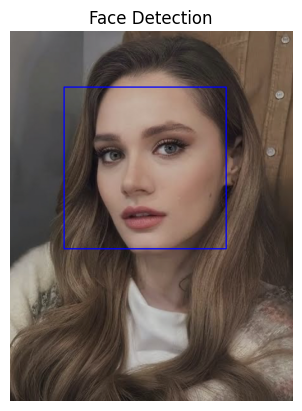

In [ ]:
!pip install opencv-python==4.7.0.72
import cv2
import matplotlib.pyplot as plt

face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

img = cv2.imread('/content/drive/MyDrive/IMG_3303.jpg')
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

faces = face_cascade.detectMultiScale(gray, 1.1, 4)

for (x, y, w, h) in faces:
    cv2.rectangle(img, (x, y), (x+w, y+h), (255, 0, 0), 2)

plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title('Face Detection')
plt.axis('off')
plt.show()

In [ ]:
from tensorflow.keras.models import load_model

In [ ]:
model.save('my_model.keras')